In [117]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [118]:
# Load the preprocessed data
df = pd.read_csv('processed_data.csv')

In [119]:
# Display initial data overview
print(df.head())
print(df.isnull().sum())

  Commodity             Market  Wholesale  Retail  Supply Volume   County  \
0  Tomatoes   Nairobi Wakulima      45.00   120.0         4000.0  Nairobi   
1  Tomatoes       Kabati Kitui      68.57   100.0         4970.0    Kitui   
2  Tomatoes   Kiria-ini Market     100.00   100.0          800.0  Muranga   
3  Tomatoes            Kinango      77.78   100.0         6000.0    Kwale   
4  Tomatoes  Soko Mjinga Wajir     112.00   100.0         3500.0    Wajir   

         Date  Month  
0  2024-04-25      4  
1  2024-04-25      4  
2  2024-04-25      4  
3  2024-04-25      4  
4  2024-04-25      4  
Commodity          0
Market             0
Wholesale        547
Retail           146
Supply Volume      0
County             5
Date               0
Month              0
dtype: int64


In [120]:
# Convert Date to datetime format
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

In [121]:
# Handle missing values
df.fillna(method='ffill', inplace=True)  # Forward fill for time series consistency

In [122]:
def one_hot_encoding(df, columns):
    """Perform one-hot encoding for categorical features."""
    valid_columns = [col for col in columns if col in df.columns]
    if not valid_columns:
        raise ValueError("None of the specified columns exist in the dataframe.")
    one_hot_encoder = ce.OneHotEncoder(cols=valid_columns, return_df=True, use_cat_names=True)
    return one_hot_encoder.fit_transform(df)


In [123]:
# Encode categorical variables
categorical_columns = [col for col in ["Market", "County", "Commodity"] if col in df.columns]
df = one_hot_encoding(df, categorical_columns)

In [124]:
# Ensure numerical columns exist before feature selection
features_to_drop = [col for col in ["Retail", "Wholesale", "Date"] if col in df.columns]
X = df.drop(columns=features_to_drop) if features_to_drop else df
Y = df["Retail"] if "Retail" in df.columns else df.get("Wholesale")

In [125]:
# Ensure target variable exists
if Y is None:
    raise ValueError("Target variable not found in the dataset.")

In [126]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=27)

In [127]:
# Initialize PyCaret setup
train, test = train_test_split(df, test_size=0.25, random_state=27)
target_col = "Retail" if "Retail" in df.columns else "Wholesale"
experiment = setup(data=train, target=target_col, imputation_type='iterative')

,Description,Value
0,Session id,8680
1,Target,Retail
2,Target type,Regression
3,Original data shape,"(2250, 144)"
4,Transformed data shape,"(2250, 146)"
5,Transformed train set shape,"(1575, 146)"
6,Transformed test set shape,"(675, 146)"
7,Numeric features,142
8,Date features,1
9,Preprocess,True


In [128]:
# Compare models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,23.8553,4694.5649,55.4892,0.2117,0.4132,3.2812,0.1250
lightgbm,Light Gradient Boosting Machine,24.0867,4585.6714,56.1362,0.1399,0.4103,2.5860,0.2820
omp,Orthogonal Matching Pursuit,26.3854,4921.0045,58.1169,0.0901,0.4432,3.2646,0.0940
ridge,Ridge Regression,24.2498,4816.8820,57.9050,0.0689,0.4148,3.1961,0.0760
lasso,Lasso Regression,28.4451,4990.5403,58.9679,0.0518,0.4684,3.2397,0.0800
llar,Lasso Least Angle Regression,28.4590,4991.9950,58.9750,0.0517,0.4685,3.2400,0.1020
en,Elastic Net,29.1632,5005.4127,59.3641,0.0280,0.4753,3.0549,0.0870
dummy,Dummy Regressor,30.8333,4913.3015,59.5968,-0.0178,0.5058,3.0129,0.0750
rf,Random Forest Regressor,19.7181,5047.9025,60.8818,-0.1695,0.3569,2.4061,1.0250
gbr,Gradient Boosting Regressor,22.4960,5180.0355,62.5212,-0.3679,0.3799,2.3443,0.3360


In [129]:
# Train a RandomForestRegressor model
random_reg = RandomForestRegressor(n_estimators=100, random_state=0)
random_reg.fit(X_train, Y_train)

RandomForestRegressor(random_state=0)

In [130]:
# Make predictions
Y_pred = random_reg.predict(X_test)

In [131]:
# Evaluate model performance
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")


MSE: 4400.292630753022
MAE: 19.536797998238946
R² Score: 0.21543420018046489


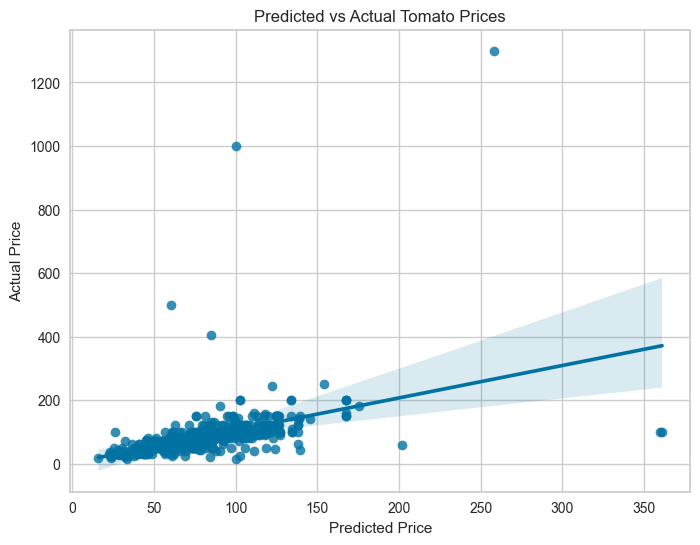

In [132]:
# Visualize predictions
plt.figure(figsize=(8, 6))
sns.regplot(x=Y_pred, y=Y_test)
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Predicted vs Actual Tomato Prices")
plt.show()